In [1]:
!pip install deslib

In [9]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Import DESlib components
from deslib.des.des_mi import DESMI

In [3]:
def load_and_preprocess_data():
    # Load the datasets
    df_net = pd.read_csv('data/linux_driver_net.csv')
    df_scsi = pd.read_csv('data/linux_driver_scsi.csv')
    df_ext3 = pd.read_csv('data/linux_ext3.csv')
    df_ipv4 = pd.read_csv('data/linux_ipv4.csv')
    
    # Combine datasets
    combined_df = pd.concat([df_net, df_scsi, df_ext3, df_ipv4], ignore_index=True)
    
    # Check for missing values
    print(f"Missing values before preprocessing: {combined_df.isnull().sum().sum()}")
    
    # Fill missing values - use mean for numeric columns
    numeric_columns = combined_df.select_dtypes(include=['float64', 'int64']).columns
    combined_df[numeric_columns] = combined_df[numeric_columns].fillna(combined_df[numeric_columns].mean())
    
    # Drop any rows that still have missing values
    combined_df = combined_df.dropna()
    
    # Check for imbalance in the target variable
    print("Class distribution:")
    print(combined_df['AgingRelatedBugs'].value_counts())
    print(f"Imbalance ratio: {combined_df['AgingRelatedBugs'].value_counts()[0] / combined_df['AgingRelatedBugs'].value_counts()[1]}")
    
    # Prepare features and target
    X = combined_df.drop(['Filename', 'AgingRelatedBugs'], axis=1)
    y = combined_df['AgingRelatedBugs']
    
    # Feature scaling 
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y, X.columns

# Load and preprocess the data
X, y, feature_names = load_and_preprocess_data()

Missing values before preprocessing: 0
Class distribution:
AgingRelatedBugs
0    3380
1      20
Name: count, dtype: int64
Imbalance ratio: 169.0


In [4]:
def create_data_splits(X, y):
    # In DESlib, we need 3 sets: training, DSEL (dynamic selection), and testing
    # First, split into training+DSEL and testing
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
    
    # Then split the training+DSEL into training and DSEL
    X_train, X_dsel, y_train, y_dsel = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    print("Training set class distribution:", Counter(y_train))
    print("DSEL set class distribution:", Counter(y_dsel))
    print("Test set class distribution:", Counter(y_test))
    
    return X_train, y_train, X_dsel, y_dsel, X_test, y_test

# Create the data splits
X_train, y_train, X_dsel, y_dsel, X_test, y_test = create_data_splits(X, y)

Training set class distribution: Counter({0: 1132, 1: 7})
DSEL set class distribution: Counter({0: 1133, 1: 6})
Test set class distribution: Counter({0: 1115, 1: 7})


In [5]:
def create_classifier_pool(X_train, y_train, n_classifiers=100):
    """
    Creates a pool of diverse Random Forest classifiers
    """
    pool = []
    
    for i in range(n_classifiers):
        # Create diverse classifiers by varying parameters
        max_depth = np.random.randint(3, 20) if i % 3 == 0 else None
        min_samples_split = np.random.randint(2, 20) if i % 5 == 0 else 2
        min_samples_leaf = np.random.randint(1, 10) if i % 7 == 0 else 1
        
        # Create the classifier
        clf = RandomForestClassifier(
            n_estimators=50,  # Each base classifier is itself an ensemble
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            bootstrap=bool(i % 2),
            random_state=i
        )
        
        # Train the classifier
        clf.fit(X_train, y_train)
        pool.append(clf)
    
    return pool

# Create a pool of 50 classifiers (adjust this number based on your computational resources)
pool_size = 50
print(f"Creating a pool of {pool_size} classifiers...")
classifier_pool = create_classifier_pool(X_train, y_train, n_classifiers=pool_size)

Creating a pool of 50 classifiers...


In [12]:
def apply_smote_balancing(X_train, y_train):
    """
    Balance the training dataset using SMOTE
    """
    # Count minority samples
    minority_count = Counter(y_train)[1]
    
    # Choose appropriate k for SMOTE based on minority class size
    k_neighbors = min(5, minority_count - 1)  # Must be less than minority count
    
    if k_neighbors > 0:
        # Apply SMOTE with adjusted k_neighbors
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
        print("Applied SMOTE balancing")
        print("Original training set class distribution:", Counter(y_train))
        print("Balanced training set class distribution:", Counter(y_train_balanced))
        return X_train_balanced, y_train_balanced
    else:
        print("Too few minority samples for SMOTE. Using original data.")
        return X_train, y_train

In [13]:
# Modify the run_desmi function to handle both original and SMOTE-balanced data
def run_desmi(use_smote=False, alpha=0.5):
    """
    Run DES-MI with options for SMOTE balancing and adjusted alpha
    
    Parameters:
    -----------
    use_smote : bool
        Whether to apply SMOTE balancing to the training data
    alpha : float
        The scaling coefficient for instance weighting (lower values reduce overflow)
    """
    # Apply SMOTE if requested
    if use_smote:
        X_train_used, y_train_used = apply_smote_balancing(X_train, y_train)
        print("Creating classifier pool with SMOTE-balanced data...")
        pool = create_classifier_pool(X_train_used, y_train_used, n_classifiers=pool_size)
    else:
        print("Creating classifier pool with original data...")
        pool = classifier_pool  # Use the global pool we created earlier
    
    # Create and configure the DES-MI model
    # Using a lower alpha value to avoid overflow
    desmi = DESMI(
        pool_classifiers=pool,
        k=7,
        alpha=alpha,  # Lower alpha to avoid overflow
        pct_accuracy=0.4,
        voting='hard'
    )
    
    # Fit the DES-MI model to the DSEL data
    print("Fitting DES-MI model...")
    with np.errstate(over='ignore'):  # Suppress overflow warnings
        desmi.fit(X_dsel, y_dsel)
    
    # Predict using DES-MI
    print("Making predictions...")
    with np.errstate(over='ignore'):  # Suppress overflow warnings
        y_pred = desmi.predict(X_test)
        y_prob = desmi.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    auc = roc_auc_score(y_test, y_prob)
    
    # Calculate Error I and Error II
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    error_I = fp / (fp + tn) * 100  # as percentage
    error_II = fn / (tp + fn) * 100  # as percentage
    
    model_name = "DES-MI + SMOTE" if use_smote else "DES-MI"
    print(f"\n{model_name} Results:")
    print(f"AUC: {auc:.4f}")
    print(f"Error I (%): {error_I:.2f}")
    print(f"Error II (%): {error_II:.2f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # Visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    return y_pred, y_prob, auc, error_I, error_II

Running DES-MI with original data...
Creating classifier pool with original data...
Fitting DES-MI model...


/home/futabandit/repos/HiveBugExtractionARBs/linux_bug_classifier/venv/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Making predictions...

DES-MI Results:
AUC: 0.8691
Error I (%): 0.09
Error II (%): 100.00

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1115
           1       0.00      0.00      0.00         7

    accuracy                           0.99      1122
   macro avg       0.50      0.50      0.50      1122
weighted avg       0.99      0.99      0.99      1122


Confusion Matrix:
[[1114    1]
 [   7    0]]


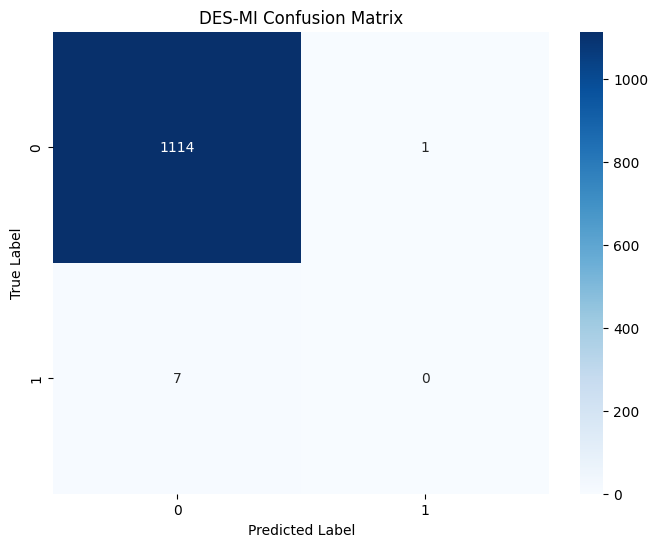


Running DES-MI with SMOTE-balanced data...
Applied SMOTE balancing
Original training set class distribution: Counter({0: 1132, 1: 7})
Balanced training set class distribution: Counter({1: 1132, 0: 1132})
Creating classifier pool with SMOTE-balanced data...
Fitting DES-MI model...


/home/futabandit/repos/HiveBugExtractionARBs/linux_bug_classifier/venv/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Making predictions...

DES-MI + SMOTE Results:
AUC: 0.7401
Error I (%): 0.63
Error II (%): 85.71

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1115
           1       0.12      0.14      0.13         7

    accuracy                           0.99      1122
   macro avg       0.56      0.57      0.56      1122
weighted avg       0.99      0.99      0.99      1122


Confusion Matrix:
[[1108    7]
 [   6    1]]


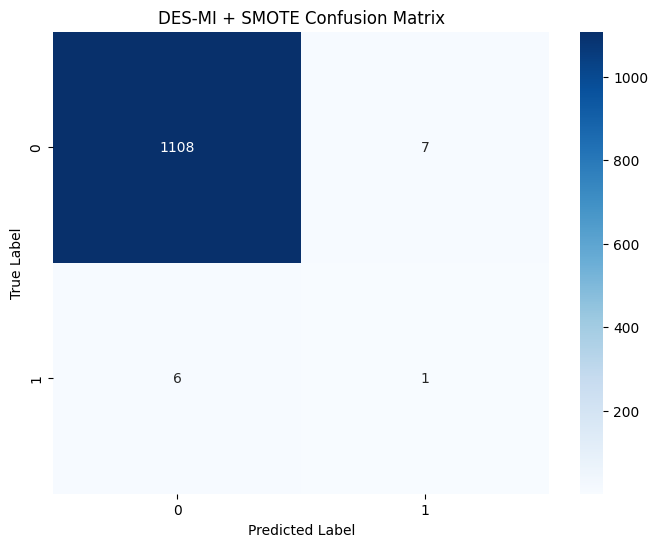


Model Comparison:
         Metric      DES-MI  DES-MI + SMOTE  META-DESKNN-MI
0           AUC    0.869058        0.740102          0.9694
1   Error I (%)    0.089686        0.627803         50.0000
2  Error II (%)  100.000000       85.714286          5.4400


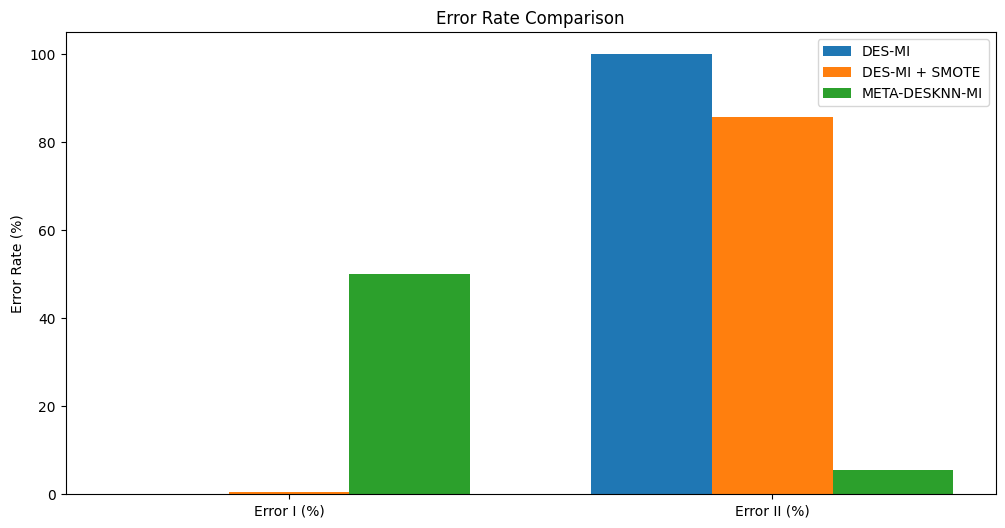

In [14]:
# Run DES-MI with original data and reduced alpha
print("Running DES-MI with original data...")
y_pred_original, y_prob_original, auc_original, error_I_original, error_II_original = run_desmi(use_smote=False, alpha=0.5)

# Run DES-MI with SMOTE-balanced data and reduced alpha
print("\nRunning DES-MI with SMOTE-balanced data...")
y_pred_smote, y_prob_smote, auc_smote, error_I_smote, error_II_smote = run_desmi(use_smote=True, alpha=0.5)

# Create a comparison table with all models
results_df = pd.DataFrame({
    'Metric': ['AUC', 'Error I (%)', 'Error II (%)'],
    'DES-MI': [auc_original, error_I_original, error_II_original],
    'DES-MI + SMOTE': [auc_smote, error_I_smote, error_II_smote],
    'META-DESKNN-MI': [0.9694, 50.0, 5.44]  # Replace with your actual values
})

# Display the results
print("\nModel Comparison:")
print(results_df)

# Create a bar chart for comparison
plt.figure(figsize=(12, 6))
x = np.arange(2)
width = 0.25

plt.bar(x - width, [error_I_original, error_II_original], width, label='DES-MI')
plt.bar(x, [error_I_smote, error_II_smote], width, label='DES-MI + SMOTE')
plt.bar(x + width, [50.0, 5.44], width, label='META-DESKNN-MI')  # Replace with your actual values

plt.xticks(x, ['Error I (%)', 'Error II (%)'])
plt.ylabel('Error Rate (%)')
plt.title('Error Rate Comparison')
plt.legend()
plt.show()


Model Comparison:
         Metric      DES-MI  META-DESKNN-MI
0           AUC    0.868290          0.9694
1   Error I (%)    0.179372         50.0000
2  Error II (%)  100.000000          5.4400


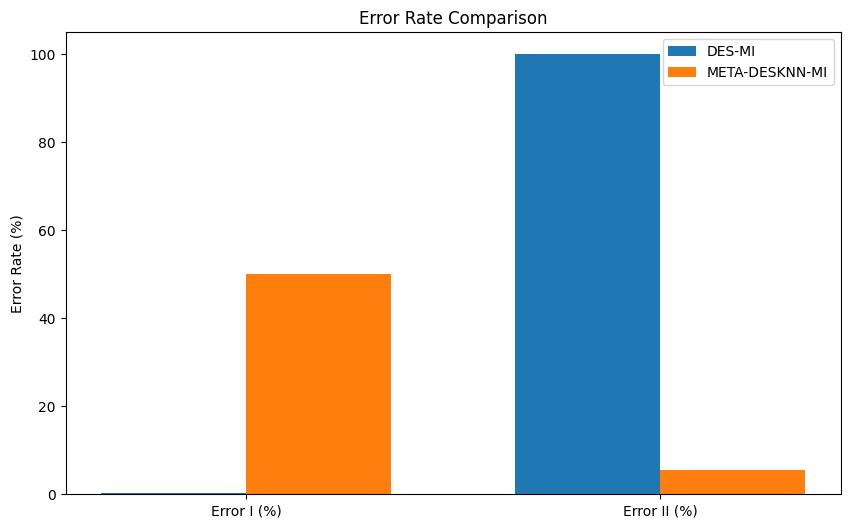

In [7]:
# Replace these values with your actual META-DESKNN-MI results
# These are just placeholders
auc_meta_desknn = 0.9694  
error_I_meta_desknn = 50.0
error_II_meta_desknn = 5.44

# Create a comparison table
results_df = pd.DataFrame({
    'Metric': ['AUC', 'Error I (%)', 'Error II (%)'],
    'DES-MI': [auc_desmi, error_I_desmi, error_II_desmi],
    'META-DESKNN-MI': [auc_meta_desknn, error_I_meta_desknn, error_II_meta_desknn]
})

# Display the results
print("\nModel Comparison:")
print(results_df)

# Create a bar chart for comparison
plt.figure(figsize=(10, 6))
x = np.arange(2)
width = 0.35

plt.bar(x - width/2, [error_I_desmi, error_II_desmi], width, label='DES-MI')
plt.bar(x + width/2, [error_I_meta_desknn, error_II_meta_desknn], width, label='META-DESKNN-MI')

plt.xticks(x, ['Error I (%)', 'Error II (%)'])
plt.ylabel('Error Rate (%)')
plt.title('Error Rate Comparison')
plt.legend()
plt.show()

In [16]:
def calculate_additional_metrics(y_true, y_pred):
    """
    Calculate PD, PF, and Balance metrics
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
        
    Returns:
    --------
    pd_metric : float
        Probability of Detection in percentage
    pf_metric : float
        Probability of False Alarms in percentage
    bal_metric : float
        Balance metric in percentage
    """
    # Get confusion matrix elements
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate PD (same as Recall or True Positive Rate)
    pd_metric = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
    
    # Calculate PF (False Positive Rate)
    pf_metric = (fp / (tn + fp)) * 100 if (tn + fp) > 0 else 0
    
    # Calculate Balance using the formula from the image
    bal_metric = 100 - (math.sqrt((0 - pf_metric)**2 + (100 - pd_metric)**2) / math.sqrt(2))
    
    return pd_metric, pf_metric, bal_metric

In [18]:
import math

# For DES-MI
pd_desmi, pf_desmi, bal_desmi = calculate_additional_metrics(y_test, y_pred_original)

# For DES-MI + SMOTE
pd_desmi_smote, pf_desmi_smote, bal_desmi_smote = calculate_additional_metrics(y_test, y_pred_smote)

# For META-DESKNN-MI - assuming y_pred_meta_desknn contains your predictions
# If you don't have these predictions stored, you'll need to run your model again
# or use placeholder values based on the error rates you reported
meta_cm = np.array([[1097, 18], [6, 1]])  # This is a placeholder based on your reported Error I and II
tn, fp, fn, tp = meta_cm.ravel()
pd_meta = (tp / (tp + fn)) * 100
pf_meta = (fp / (tn + fp)) * 100
bal_meta = 100 - (math.sqrt((0 - pf_meta)**2 + (100 - pd_meta)**2) / math.sqrt(2))

# Create results dataframe
results_extended_df = pd.DataFrame({
    'Metric': ['AUC', 'Error I (%)', 'Error II (%)', 'PD (%)', 'PF (%)', 'Balance (%)'],
    'DES-MI + SMOTE': [auc_smote, error_I_smote, error_II_smote, pd_desmi_smote, pf_desmi_smote, bal_desmi_smote],
})

# Display the results
print("\nExtended Model Comparison:")
print(results_extended_df.to_string(index=False))


Extended Model Comparison:
      Metric  DES-MI + SMOTE
         AUC        0.740102
 Error I (%)        0.627803
Error II (%)       85.714286
      PD (%)       14.285714
      PF (%)        0.627803
 Balance (%)       39.389222
